In [55]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os





# Loading of the training set.

We peek the datset using the function head() to see its composition.

In [56]:
from collections import Counter
from matplotlib import pyplot as plt


In [57]:
df = pd.read_csv("train.tsv.gz",sep="\t",header=0)
pd.set_option('display.max_colwidth', 150)

df.head()

,id,text,label
0,12322,you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe,generated
1,1682,"The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessar...",generated
2,22592,"I have not been tweeting a lot lately, but I did in November, and it was a really good month. I also",generated
3,17390,I pass my exam and really thankgod for that but idk where will I go for shsmy result is ah,human
4,30453,"The template will have 3 parts: a mustache shape, a bow tie shape, and a skinny rectangle. The mustache shape will eventually make the bow loops. ...",human


Let's check the size of the data set:

In [58]:
print(f"No. of sentences: {len(df)}")

No. of sentences: 33845


We have quite a few documents.
Let's see if the classes are distributed over the population.

In [59]:
df['text'][0]

'you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe'

In [60]:
df['lenght']=df['text'].str.len()
max=df['lenght'].max()
min=df['lenght'].min()
avg=df['lenght'].mean()
print( 'maximum value: '+str(max))
print('minimum value: '+str(min))
print('average value: '+str(avg))
df.head()

maximum value: 669
minimum value: 3
average value: 305.25058354262075


,id,text,label,lenght
0,12322,you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe,generated,100
1,1682,"The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessar...",generated,571
2,22592,"I have not been tweeting a lot lately, but I did in November, and it was a really good month. I also",generated,100
3,17390,I pass my exam and really thankgod for that but idk where will I go for shsmy result is ah,human,90
4,30453,"The template will have 3 parts: a mustache shape, a bow tie shape, and a skinny rectangle. The mustache shape will eventually make the bow loops. ...",human,329


I have added a feature to our datset containing the lenght of the documents.


we have 2 different categories:


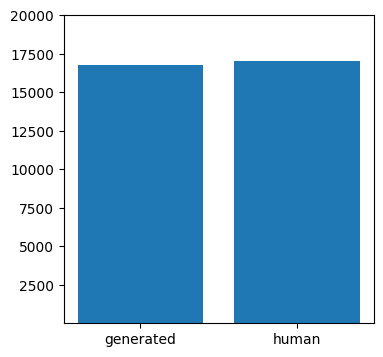

In [61]:


label_count = Counter(df['label'])

print(f"we have {len(label_count.keys())} different categories:")


plt.figure(figsize=(4, 4))
plt.bar(range(len(label_count)), label_count.values())
plt.xticks(range(len(label_count)), label_count.keys())
plt.ylim([1, 20000])
plt.show()

The categories are equally distributed.


# Search Engine

In [62]:
!pip install -q python-terrier


In [63]:
import pyterrier as pt
if not pt.started():
  pt.init()

Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents.

In the following cell, we index the dataframe's documents. The index, with all its data structures, is written into a directory that we will call index_3docs. 

In [64]:
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
df['docno']=str(df["id"])
index_ref = indexer.index(df["text"], df["docno"])
index_ref.toString()

/usr/local/lib/python3.10/dist-packages/pyterrier/index.py:628: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



13:28:20.574 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (0        12322
1         1682
2        22592
3        17390
4        30453
         ...  
33840    16850
33841     6265
33842    11284
33843      860
33844    15795
Name: id, Length: 33845, dtype: int64) - further warnings are suppressed
13:28:56.087 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 4 empty documents


'./index_3docs/data.properties'

In [65]:
index = pt.IndexFactory.of(index_ref)

In [66]:
print(index.getCollectionStatistics().toString())

Number of documents: 33845
Number of terms: 31825
Number of postings: 751277
Number of fields: 0
Number of tokens: 923471
Field names: []
Positions:   false



In [67]:
query = "potato"
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25.search(query)
br = pt.BatchRetrieve(index, wmodel="TF_IDF")
queries=br.search(query)
queries.head()

,qid,docid,docno,rank,score,query
0,1,21593,0 123221 16822 225923 173904 30453 ... 33840 1685033841 626533842 1128433843 86033844 ...,0,8.106677,potato
1,1,13963,0 123221 16822 225923 173904 30453 ... 33840 1685033841 626533842 1128433843 86033844 ...,1,8.024425,potato
2,1,5780,0 123221 16822 225923 173904 30453 ... 33840 1685033841 626533842 1128433843 86033844 ...,2,7.984238,potato
3,1,24231,0 123221 16822 225923 173904 30453 ... 33840 1685033841 626533842 1128433843 86033844 ...,3,7.944453,potato
4,1,25694,0 123221 16822 225923 173904 30453 ... 33840 1685033841 626533842 1128433843 86033844 ...,4,7.827439,potato


Word Embedding

In [68]:
!pip install --upgrade gensim
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import re
from pandas.core.common import flatten
from gensim.models.word2vec import Word2Vec
import random
from sklearn.manifold import TSNE
import plotly.express as px

In [70]:

# remove newline characters
docs = [re.sub('\n', ' ', doc) for doc in df.text]
# remove email addresses
docs = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', doc) for doc in docs]
# split sentences 
sentences = [re.split('[?!.]\s', doc) for doc in docs]
sentences[:3]

[['you need to stop the engine and wait until it stops',
  'This is how I would do it: // Check if its safe'],
 ['The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessary or appropriate',
  '2',
  'The Commission may request any relevant information from the Member States, the Council, the European Parliament, international organizations, bodies or specialized agencies',
  '3',
  'The Commission shall ensure adequate access by the competent national authorities for the purpose of implementing this Regulation',
  '4',
  'The Commission shall give special attention to the social dimension of the programme',
  '5',
  'The'],
 ['I have not been tweeting a lot lately, but I did in November, and it was a really good month',
  'I also']]

In [71]:
sentences = list(flatten(sentences))
sentences[:20]

['you need to stop the engine and wait until it stops',
 'This is how I would do it: // Check if its safe',
 'The Commission shall publish the report; an interim report at least once every two years, and whenever it considers that such a report is necessary or appropriate',
 '2',
 'The Commission may request any relevant information from the Member States, the Council, the European Parliament, international organizations, bodies or specialized agencies',
 '3',
 'The Commission shall ensure adequate access by the competent national authorities for the purpose of implementing this Regulation',
 '4',
 'The Commission shall give special attention to the social dimension of the programme',
 '5',
 'The',
 'I have not been tweeting a lot lately, but I did in November, and it was a really good month',
 'I also',
 'I pass my exam and really thankgod for that but idk where will I go for shsmy result is ah',
 'The template will have 3 parts: a mustache shape, a bow tie shape, and a skinny rectang

In [72]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
# remove sentences that are only 1 word long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['you', 'need', 'to', 'stop', 'the', 'engine', 'and', 'wait', 'until', 'it', 'stops']
['this', 'is', 'how', 'i', 'would', 'do', 'it', 'check', 'if', 'its', 'safe']
['the', 'commission', 'shall', 'publish', 'the', 'report', 'an', 'interim', 'report', 'at', 'least', 'once', 'every', 'two', 'years', 'and', 'whenever', 'it', 'considers', 'that', 'such', 'a', 'report', 'is', 'necessary', 'or', 'appropriate']
['the', 'commission', 'may', 'request', 'any', 'relevant', 'information', 'from', 'the', 'member', 'states', 'the', 'council', 'the', 'european', 'parliament', 'international', 'organizations', 'bodies', 'or', 'specialized', 'agencies']
['the', 'commission', 'shall', 'ensure', 'adequate', 'access', 'by', 'the', 'competent', 'national', 'authorities', 'for', 'the', 'purpose', 'of', 'implementing', 'this', 'regulation']
['the', 'commission', 'shall', 'give', 'special', 'attention', 'to', 'the', 'social', 'dimension', 'of', 'the', 'programme']
['i', 'have', 'not', 'been', 'tweeting', 'a', 

Finally we have the data in the right format for training Word2Vec, so we can provide it to the algorithm. For parameters, we set:

the embedding size to be 30,
the minimum count for any vocabulary term to be 5
the size of the context window to 10.

In [73]:
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

Vocubalary

In [74]:
len(model.wv)

12946

In [75]:
term ='semen'
model.wv.most_similar(term)

[('prolonged', 0.9148003458976746),
 ('mortality', 0.9097235798835754),
 ('radiation', 0.9086166024208069),
 ('pubic', 0.8935681581497192),
 ('donations', 0.89178067445755),
 ('sown', 0.8905121088027954),
 ('seating', 0.8886496424674988),
 ('centuries', 0.888372540473938),
 ('inhabitants', 0.8868842124938965),
 ('criticism', 0.8839629888534546)]

In [76]:
sample = random.sample(list(model.wv.key_to_index), 500)
print(sample)
word_vectors = model.wv[sample]
word_vectors

['birds', 'lowered', '1291', 'herewith', 'blinking', 'buffing', 'holy', 'entries', 'suspension', 'smartboard', 'steam', 'infectious', 'expire', 'dntbh8n', 'performance', '425', 'handy', '30', 'sight', 'vegas', 'ladder', 'humor', 'salmon', 'region', 'spells', 'roads', 'commonly', 'rape', 'nutrient', 'compress', 'diverse', 'nut', '1994', 'stomach', 'facing', 'exchanged', 'energy', 'pocket', 'hotel', 'cities', 'conjunction', 'snakes', 'cheer', 'fractions', 'jackets', 'ie', 'explaining', 'scheme', 'performing', 'invalid', 'cheating', 'award', 'skillet', 'sport', 'overly', 'often', 'grace', 'wrinkles', 'pollutants', 'stepdad', 'sardines', 'religious', 'examine', 'iphone', 'fungi', 'snowman', 'molly', 'finder', 'browns', 'hormones', 'exporting', '350', 'substance', 'supplementary', 'revenues', 'email', 'abrasive', 'selective', 'stamp', 'ingrown', 'chemotherapy', 'distort', 'definitively', '936', 'spring', 'kale', 'azerbaijan', '6302', 'parentheses', 'say', 'films', 'grip', 'ddlovato', 'antib

array([[-0.31205258, -0.26565337, -0.03283921, ...,  0.29948512,
        -0.56976616, -0.5301402 ],
       [-0.00518655, -0.03727358,  0.19427937, ...,  0.199449  ,
        -0.00404289, -0.2290101 ],
       [ 0.02388928, -0.15647617,  0.02632035, ...,  0.06869216,
        -0.17362761, -0.10161626],
       ...,
       [ 0.11466417, -0.3340318 ,  0.3690369 , ...,  0.2509292 ,
        -0.1814387 , -0.3345276 ],
       [-0.08393715, -1.3361847 , -0.9618745 , ..., -0.840948  ,
         1.1770287 ,  1.029038  ],
       [ 0.0369123 , -0.09952261,  0.25981864, ...,  0.18541683,
        -0.07624012, -0.20733565]], dtype=float32)

In [77]:
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

In [78]:
x, y, z = np.transpose(tsne_embedding)

In [79]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

# Classifying with word embeddings

In [84]:
import gensim.downloader as api
import string
import re
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [85]:
df.sample(frac=1)
n=len(df)
df['label'] = df['label'].replace({'generated':0, 'human':1})
# df['label'] = df['label'].replace({'A':0, 'B':1,'C':2,'D':3,'E':4,'F':5,})
train, test = train_test_split(df, test_size=0.3)
valid, test = train_test_split(df, test_size=0.6)

In [86]:
model_wiki = api.load("glove-wiki-gigaword-50")

In [87]:

regex = '[' + string.punctuation + ']'

def vectorize(docs, embedding_model=model_wiki, useSum=False):
    vectors = np.zeros((len(docs),50))
    for i in range(len(docs)):
        tokens = re.sub(regex, '', docs[i].lower()).split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [88]:
train_x_vector = vectorize(np.array(train.text))

In [89]:
train_y=train.label

In [90]:

lr_model =ExtraTreesClassifier(n_estimators=500).fit(train_x_vector, train_y)
print(lr_model)

ExtraTreesClassifier(n_estimators=500)


Accuracy: 0.9266262865021914


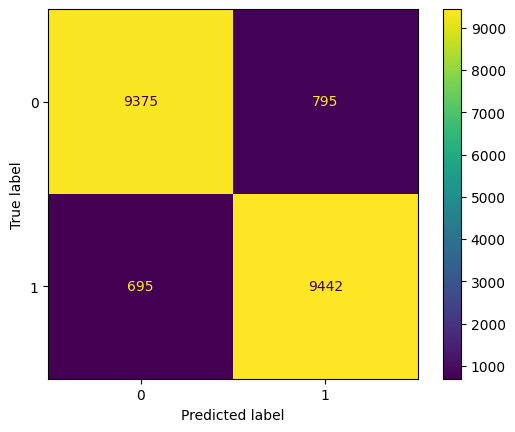

In [91]:
valid_x_vector = vectorize(np.array(test.text))
pred_y = lr_model.predict(valid_x_vector)

print(f'Accuracy: {accuracy_score(test.label, pred_y)}')


ConfusionMatrixDisplay.from_estimator(lr_model, valid_x_vector, test.label, values_format='d')  
plt.show()

We create a vectorizer and we fit our data into.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [93]:
documents=np.array(df['text'])
labels = np.array(df['label'])

In [94]:

vectorizer.fit(documents)
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 11557


We obtained a relative small vocubalary only 11557 words.

In [95]:
vector_documents = vectorizer.transform(documents)

we try to see if the actual class can be classified simply by using a cluster algorithm.


In [96]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('stops', 0.5175669643660845),
 ('engine', 0.4398088411851892),
 ('safe', 0.3649985322600579),
 ('stop', 0.3635661001777833),
 ('wait', 0.3535613203867755),
 ('check', 0.3108401996160741),
 ('need', 0.22729088387073065)]

In [97]:
for i in range(1,200):
    if (labels[i] == labels[1]):
      print('Similarity:', vector_documents[0].multiply(vector_documents[i]).sum())

Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.021988643765721246
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.023254981000023926
Similarity: 0.0
Similarity: 0.0
Similarity: 0.05465414018686425
Similarity: 0.0
Similarity: 0.0
Similarity: 0.04271130589763102
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Simila

As we can see from this results using vectorization we can't achieve good results. Sentences with the same label share almost 0 similarity

In [98]:
k = len(set(labels))
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 67084.4746223416.
Iteration 1, inertia 33392.09847932085.
Iteration 2, inertia 33308.75747079349.
Iteration 3, inertia 33186.99125674895.
Iteration 4, inertia 32846.08480709024.
Iteration 5, inertia 32738.428579477193.
Iteration 6, inertia 32701.090729042884.
Iteration 7, inertia 32684.420324122097.
Iteration 8, inertia 32676.32200954779.
Iteration 9, inertia 32672.259157364006.
Iteration 10, inertia 32670.244503493144.
Iteration 11, inertia 32669.285943947547.
Iteration 12, inertia 32668.707969005707.
Iteration 13, inertia 32668.341695537827.
Iteration 14, inertia 32668.161644015836.
Iteration 15, inertia 32668.11891182691.
Iteration 16, inertia 32668.111221099527.
Iteration 17, inertia 32668.09879881628.
Iteration 18, inertia 32668.07836230555.
Iteration 19, inertia 32668.063546554517.
Iteration 20, inertia 32668.054540119712.
Iteration 21, inertia 32668.043044294143.
Iteration 22, inertia 32668.036725095088.
Iteration 23, inertia 32668.03

KMeans(max_iter=100, n_clusters=2, n_init=2, random_state=2307, verbose=True)

In [99]:


print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(labels, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(labels, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(labels, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(labels, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 32668.032303848704
Silhouette coefficient: 0.011687671020057765
Extrinsic evaluation measures:
Homogeneity: 0.06476441677697967
Completeness: 0.12404977572786596
V-measure: 0.0850996555899704
Adjusted Rand-Index: 0.03102009598058132


As we can see from this metrics and as we expect it perfomed terribly.
We can say that the content of the sentences is not related to the label.